# Task2 : Market Basket Analysis Using Apriori Algorithm

In [6]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import PowerTransformer, StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [8]:
#data understanding
df = pd.read_excel('market.xlsx')
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   BillNo      522064 non-null  object        
 1   Itemname    520609 non-null  object        
 2   Quantity    522064 non-null  int64         
 3   Date        522064 non-null  datetime64[ns]
 4   Price       522064 non-null  float64       
 5   CustomerID  388023 non-null  float64       
 6   Country     522064 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 27.9+ MB


In [10]:
#data cleaning
df.shape

(522064, 7)

In [11]:
df.describe().round(2)

,Quantity,Price,CustomerID
count,522064.00,522064.00,388023.00
mean,10.09,3.83,15316.93
std,161.11,41.90,1721.85
min,-9600.00,-11062.06,12346.00
25%,1.00,1.25,13950.00
50%,3.00,2.08,15265.00
75%,10.00,4.13,16837.00
max,80995.00,13541.33,18287.00


In [12]:
#take a column with string datatype
df['BillNo'] = df['BillNo'].astype('str')
df.sort_values('BillNo',ascending=False)

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
288774,A563187,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom
288773,A563186,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
288772,A563185,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
522063,581587,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France
522054,581587,ALARM CLOCK BAKELIKE GREEN,4,2011-12-09 12:50:00,3.75,12680.0,France
...,...,...,...,...,...,...,...
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom


In [13]:
#deleting transaction cancelled rows
df = df[~df['BillNo'].str.contains('C')]

In [14]:
df.shape

(522064, 7)

In [15]:
def missingvalue(data):
    missing_value = data.isnull().sum(axis = 0).reset_index()
    missing_value.columns = ['variable', 'number_of_missing']
    missing_value['percentage_of_missing'] = (missing_value['number_of_missing'])/data.shape[0]*100
    mv = missing_value.sort_values('percentage_of_missing', ascending = False).reset_index(drop=True)
    return mv
missingvalue(df)

,variable,number_of_missing,percentage_of_missing
0,CustomerID,134041,25.675205
1,Itemname,1455,0.278701
2,BillNo,0,0.000000
3,Quantity,0,0.000000
4,Date,0,0.000000
5,Price,0,0.000000
6,Country,0,0.000000


In [16]:
#dropping missing values
df = df.dropna(subset = ['CustomerID', 'Itemname'])

In [17]:
missingvalue(df)

,variable,number_of_missing,percentage_of_missing
0,BillNo,0,0.0
1,Itemname,0,0.0
2,Quantity,0,0.0
3,Date,0,0.0
4,Price,0,0.0
5,CustomerID,0,0.0
6,Country,0,0.0


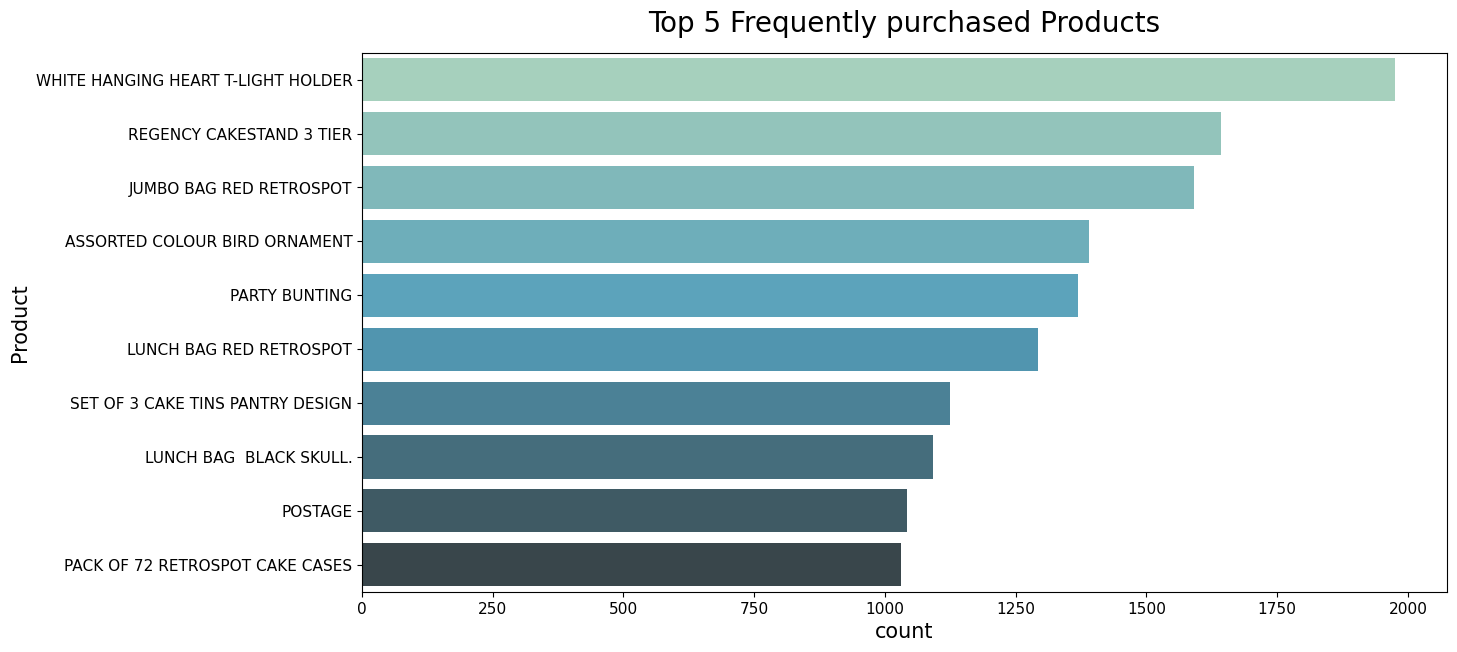

In [18]:
#most purchased products
plt.figure(figsize =(14,7))

ax = sns.countplot(y=df["Itemname"], order = df["Itemname"].value_counts().iloc[:10].index, palette="GnBu_d")

ax.set_title("Top 5 Frequently purchased Products", size = 20, pad=15) 
ax.set_xlabel("count", size = 15)
ax.set_ylabel("Product", size = 15)
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)

plt.show()



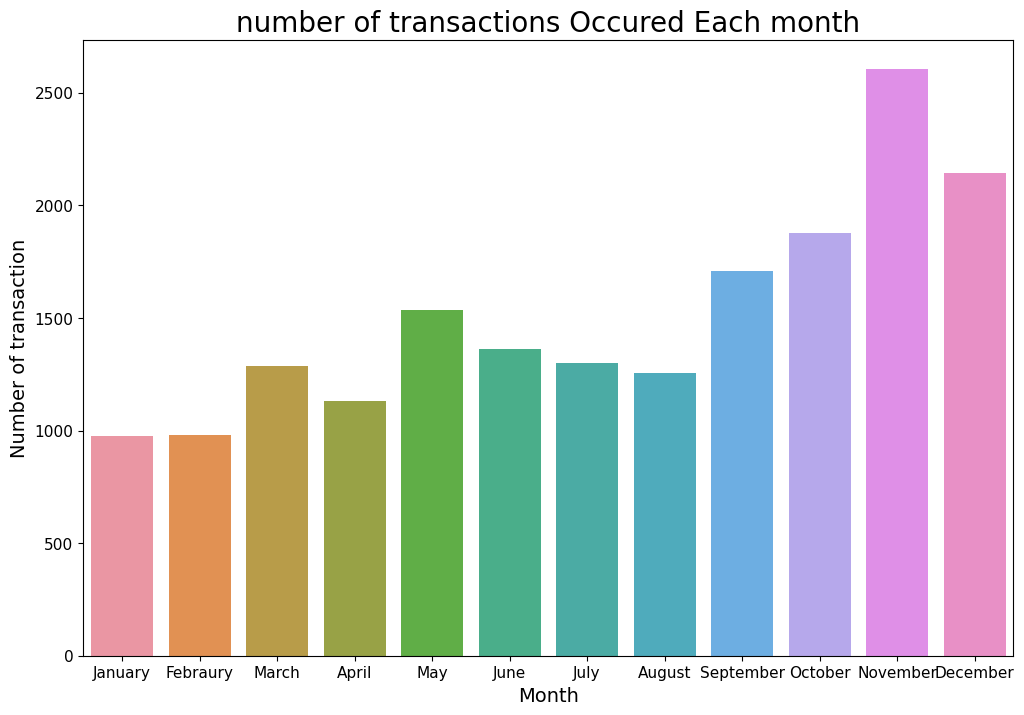

In [28]:
#no.of orders per month
order_month = df.groupby(df['Date'].dt.month)['BillNo'].nunique()

plt.figure(figsize =(12,8))
ax = sns.barplot(x = 'Date', y = 'BillNo', data = order_month.reset_index())
ax.set_title("number of transactions Occured Each month", size = 20)

ax.set_xlabel('Month', size=14)

ax.set_ylabel('Number of transaction', size=14)

ax.xaxis.set_tick_params(labelsize = 11) 
ax.yaxis.set_tick_params(labelsize = 11)

ax.set_xticklabels(['January','Febraury','March','April','May','June','July','August','September','October','November','December'])
plt.show()

In [33]:
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [38]:
price_cust = pd.pivot_table(df, index='CustomerID', values='BillNo', aggfunc=pd.Series.nunique)
print('following is the list of customers:')
price_cust.sort_values('BillNo',ascending=False)

following is the list of customers:


,BillNo
CustomerID,
12748.0,210
17841.0,124
13089.0,97
14606.0,93
15311.0,91
...,...
16248.0,1
16247.0,1
13774.0,1


In [40]:
#TimeCohots
def get_month(x):
    return dt.datetime(x.year, x.month, 1)
df['InvoiceMonth'] = df['Date'].apply(get_month)

In [41]:
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country,InvoiceMonth
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


In [42]:
group = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = group.transform('min')
df

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
...,...,...,...,...,...,...,...,...,...
522059,581587,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-01,2011-08-01
522060,581587,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01,2011-08-01
522061,581587,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
522062,581587,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01


In [43]:
def date(data, column):
    year = data[column].dt.year
    month = data[column].dt.month
    day = data[column].dt.day
    return year, month, day
invoice_year, invoice_month, _ = date(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = date(df,'CohortMonth')
diff_year = invoice_year - cohort_year
diff_month = invoice_month - cohort_month

In [44]:
df['IndexTime'] = diff_year*12 + diff_month + 1
df

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country,InvoiceMonth,CohortMonth,IndexTime
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
...,...,...,...,...,...,...,...,...,...,...
522059,581587,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-01,2011-08-01,5
522060,581587,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01,2011-08-01,5
522061,581587,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01,5
522062,581587,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01,5


In [49]:
count_cohort_time = df.groupby(['CohortMonth', 'IndexTime'])['CustomerID'].apply(pd.Series.nunique)
count_cohort_time = count_cohort_time.reset_index()
cohort_time_table = count_cohort_time.pivot(index='CohortMonth', columns='IndexTime', values='CustomerID')
cohort_time_table

IndexTime,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,879.0,321.0,284.0,336.0,317.0,349.0,318.0,306.0,311.0,347.0,328.0,442.0,234.0
2011-01-01,414.0,91.0,111.0,95.0,133.0,119.0,102.0,101.0,124.0,134.0,151.0,48.0,NaN
2011-02-01,373.0,71.0,70.0,107.0,102.0,93.0,95.0,104.0,93.0,116.0,26.0,NaN,NaN
2011-03-01,446.0,67.0,114.0,89.0,100.0,73.0,119.0,103.0,124.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,63.0,60.0,62.0,59.0,67.0,64.0,77.0,21.0,NaN,NaN,NaN,NaN
2011-05-01,283.0,54.0,49.0,49.0,59.0,65.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,239.0,41.0,38.0,63.0,56.0,79.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,187.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,165.0,35.0,40.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


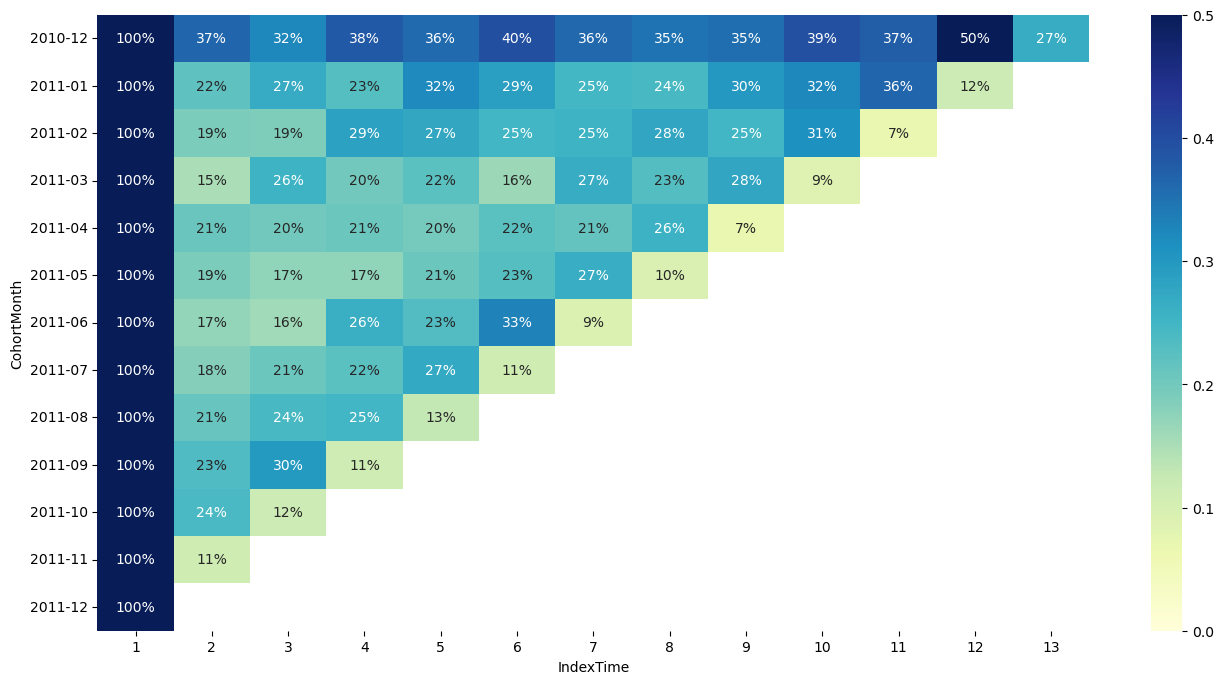

In [53]:
#customer retension rate
cohort_size = cohort_time_table.iloc[:,0]
retention = cohort_time_table.divide(cohort_size, axis = 0)
retention.index = retention.index.strftime("%Y-%m")
plt.figure(figsize=(16,8))
ax = sns.heatmap(data = retention, annot = True, annot_kws={"size":10},vmin = 0.0,vmax = 0.5, fmt = '.0%', cmap = 'YlGnBu')
plt.show()

In [54]:
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country,InvoiceMonth,CohortMonth,IndexTime
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1


Conclusion:
From the market basket analysis,it is found that customers who buy pink regency teacup and saucer tend to buy green regency teacup and saucer.we can provide more colour variants on the teacup.